In [1]:
import random 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from pathlib import Path
from collections import Counter
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import interpolate
from random import randint

from numpy.typing import ArrayLike

%load_ext autoreload
%autoreload 2

from utils import get_data, bb_to_2d

In [2]:
datapath = "../datasets/carla_dataset/"
# gcp ground condact point !
# psi richtungsvector
# bb bounding box alle 8 ecken -> 2d bounding box mit funktion
image_pv, image_tv, vehicles_pv, vehicles_tv = get_data(2, str(datapath))
all_data = [get_data(i, datapath) for i in range(1, 101)]



In [3]:
vehicles_pv

array([{'id': 198, 'gcp': [637, 276], 'psi': [605, 263], 'img': 'output/pv/255530.png', 'bb': [(699, 316), (732, 275), (718, 297), (749, 258), (569, 258), (586, 224), (592, 247), (609, 213)], 'hull': array([[479, 639],
              [281, 639],
              [245, 568],
              [244, 566],
              [241, 559],
              [227, 525],
              [132, 294],
              [121, 267],
              [120, 264],
              [120, 258],
              [123, 225],
              [127, 182],
              [128, 172],
              [166,   3],
              [167,   0],
              [399,   0],
              [479, 455]], dtype=int32), 'min_area_rect': array([[ 76,  15],
              [392, -39],
              [510, 633],
              [194, 688]])}                                                                                                                                                                                               ,
       {'id': 193, 'gcp': [475, 119], 'psi

In [4]:
hulls = []
gcps = []
box_coords = []
gcps_topview = []

for image_pv, image_tv, vehicles_pv, vehicles_tv in all_data:
    for vehicle in vehicles_pv:
        gcps.append(vehicle["gcp"])
        hulls.append(vehicle["hull"])
        box_coords.append(bb_to_2d(np.array(vehicle["bb"])))
    
    for vehicle in vehicles_tv:
        gcps_topview.append(vehicle["gcp"])

len(hulls), len(gcps)

(265, 265)

32


<BarContainer object of 23 artists>

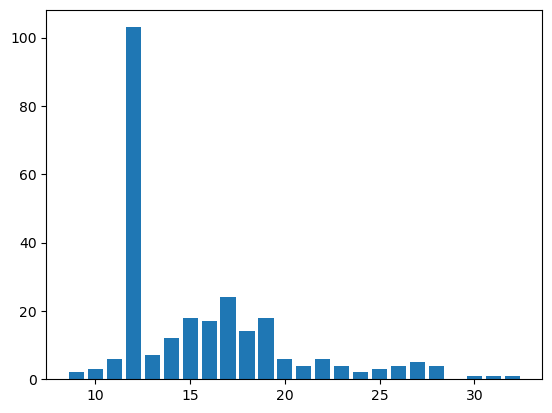

In [5]:
number_of_hulls = list(map(lambda x: len(x), hulls))
length_counter = Counter(number_of_hulls)
print(max(length_counter))
plt.bar(length_counter.keys(), length_counter.values()) # type: ignore

NameError: name 'pad_to_n' is not defined

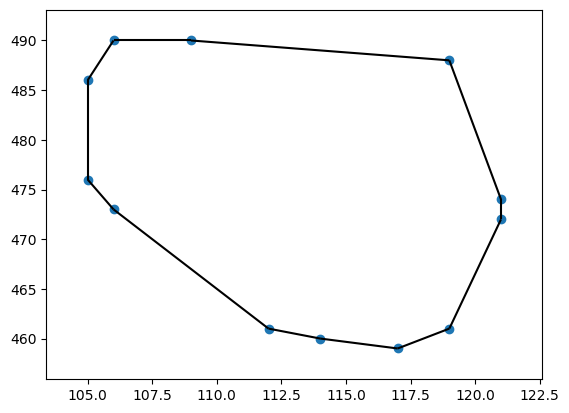

In [6]:

my_hull = hulls[10]
_=convex_hull_plot_2d(ConvexHull(my_hull))
my_hull = pad_to_n(my_hull)
_=convex_hull_plot_2d(ConvexHull(my_hull))

# Add points to always have 32 hull coordinates

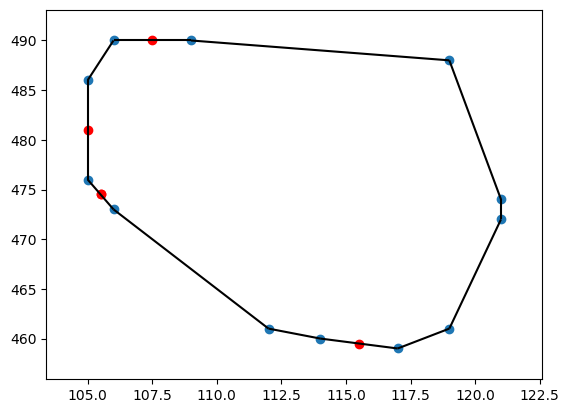

In [ ]:
test_hull = ConvexHull(hulls[0])

point_indices = np.random.randint(0, len(test_hull.points) - 2, size=5)
p1s = test_hull.points[point_indices]
p2s = test_hull.points[point_indices+1]
new_points = p2s + ((p1s-p2s) / 2)
figure, axis = plt.subplots()
_= convex_hull_plot_2d(test_hull,axis)
axis.scatter(new_points[:, 0], new_points[:, 1], color="red")

In [ ]:
padded_hulls = list(map(lambda x: pad_to_n(x), hulls))

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from ipm_evaluation.fivesafe.image_tracking.track import Track
import importlib
from bev import PositionEstimation

In [10]:
position_estimator = PositionEstimation("./ipm_evaluation/conf/homography_matrix.json", 5)

n = 0
hull = hulls[n]
box = box_coords[n] # box only needed for pedestrian
object_type = 2 # car dont pass in pedestrian
track = Track(None, object_type, 1, 1, 10)

# pt new is the gcp from top view
pt_new, _, _ = position_estimator.map_entity_and_return_relevant_points(track, hull)
pt_new = position_estimator.invert_homography(pt_new)
print()
print(f"Pt_new: {pt_new}, {gcps[n]}, gcp_tv: {gcps_topview[n]}")
#pt_new, rotated_rvec, gcps_image, gcps[n], gcps_topview[n]


Pt_new: (479.5444712391276, 130.59563855326095), [475, 119], gcp_tv: [283, 116]


In [11]:
inverted_h_matrix = position_estimator.inv_Homography_Matrix

In [12]:
point_new = [pt_new[0], pt_new[1], 1]
warped_point = np.matmul(inverted_h_matrix, point_new)
scaling = 1 / warped_point[2]
warped_point *= scaling
warped_point[:2]

array([1125.34401367,  117.39395654])

In [ ]:
import joblib

In [ ]:
classifiers = joblib.load("models/classifiers.joblib")

In [ ]:
classifiers

[{'classifier': MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60,
                                                           random_state=42)),
  'pipeline': Pipeline(steps=[('padhull', PadHull(shuffle=False)),
                  ('scaletoimage', ScaleToImage(height=480, width=640)),
                  ('flattencoordinates', FlattenCoordinates(n_coordinates=32)),
                  ('standardscaler', StandardScaler())]),
  'train_mse': 0.477911449321598,
  'test_mse': 25.805565674742713},
 {'classifier': RegressorChain(base_estimator=GradientBoostingRegressor(n_estimators=60,
                                                          random_state=42)),
  'pipeline': Pipeline(steps=[('padhull', PadHull(shuffle=False)),
                  ('scaletoimage', ScaleToImage(height=480, width=640)),
                  ('flattencoordinates', FlattenCoordinates(n_coordinates=32)),
                  ('standardscaler', StandardScaler())]),
  'train_mse': 0.4389530309000424,
  'tes

0.0


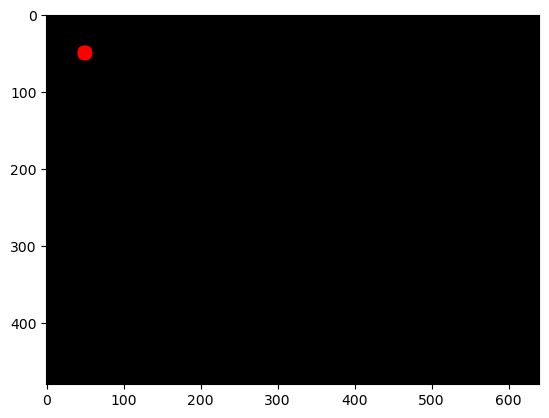

In [ ]:
image = np.zeros((480, 640, 3), dtype=np.uint8)
print(image.mean())
cv2.circle(image, (50, 50), 10, (255, 0, 0), -1)
_=plt.imshow(image)

In [ ]:
from data.data import CameraImage
from PIL import Image


In [ ]:
data = CameraImage.get_dataset(Path("../datasets/carla_dataset/"))

Loading preprocessed dataset


uint8 (480, 640, 3)


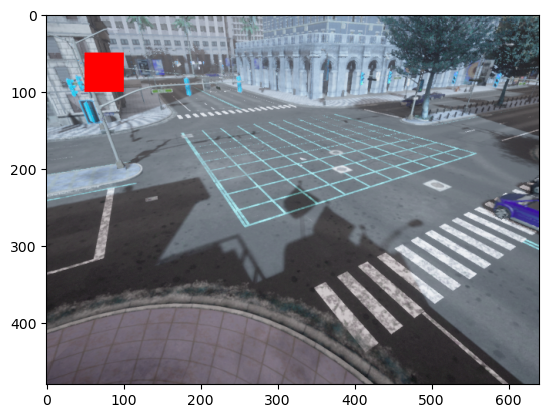

In [ ]:
image = data[1].image_pv.copy()
cv2.rectangle(image, (50, 50), (100, 100), (255, 0 , 0), -1)
print(image.dtype, image.shape)
_ = plt.imshow(image)

(480, 640, 3)


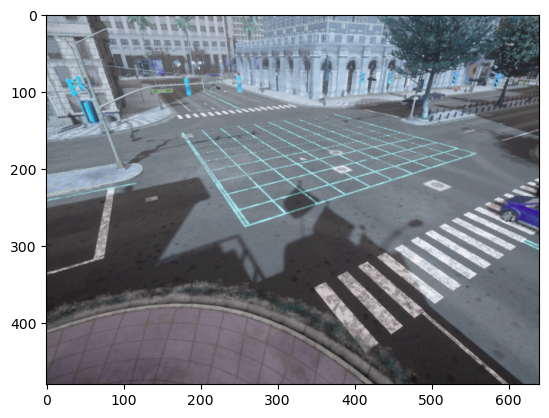

In [ ]:
image = cv2.imread("../datasets/carla_dataset/output/pv/255529.png")
print(image.shape)
_=plt.imshow(image)